# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science

## Standard Section 3: Predictor types and Feature Selection


**Harvard University**<br/>
**Fall 2018**<br/>
**Instructors:** Pavlos Protopapas, Kevin Rader<br/>
**Section Leaders:** Mehul Smriti Raje, Ken Arnold, Karan Motwani, Cecilia Garraffo<br/>

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("http://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

For this section, our goal is to discuss the complexities around different types of data features and thinking carefully about how different datatypes and collinearity issues can affect our models, whether our true goal is inference or prediction.

Specifically, we will: 
    
    1. Discuss different variable types, and techniques of “one-hot-encoding” our factor variables 
    2. Build a variable selection function that performs an exhaustive feature search overall all possible combinations of predictors 


For this section we will be using the following packages:

In [1]:
#Check Python Version
import sys
assert(sys.version_info.major==3), print(sys.version)

# Data and Stats packages
import numpy as np
import pandas as pd
from sklearn import metrics, datasets
from sklearn.model_selection import train_test_split
import statsmodels.api as sm # RUNNING FOR ME (MSR)

# Visualization packages
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
matplotlib.rcParams['figure.figsize'] = (13.0, 6.0)

# Other Helpful fucntions
import itertools
import warnings
warnings.filterwarnings("ignore")

#Aesthetic settings
from IPython.display import display
pd.set_option('display.max_rows', 999)
pd.set_option('display.width', 500)
pd.set_option('display.notebook_repr_html', True)

## 1. Extending Linear Regression by Transforming Predictors

Linear regression works great when our features are all continuous and all linearly affect the output. But often real data have more interesting characteristics. Here, we'll look at how we can extend linear regression to handle:

* Categorical predictors, like gender, which have one of a few discrete values
* Interactions between predictors, which let us model how one variable changes the effect of another.

For our dataset, we'll be using the passenger list from the Titanic, which famously sank in 1912. Let's have a look at the data. Some descriptions of the data are at https://www.kaggle.com/c/titanic/data, and here's [how seaborn preprocessed it](https://github.com/mwaskom/seaborn-data/blob/master/process/titanic.py).

In [2]:
# Load the dataset from seaborn 
titanic = sns.load_dataset("titanic")
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [4]:
# Keep only a subset of the predictors; some are redundant, others (like deck) have too many missing values.
titanic = titanic[['age', 'sex', 'class', 'embark_town', 'alone', 'fare']]

In [5]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 6 columns):
age            714 non-null float64
sex            891 non-null object
class          891 non-null category
embark_town    889 non-null object
alone          891 non-null bool
fare           891 non-null float64
dtypes: bool(1), category(1), float64(2), object(2)
memory usage: 29.8+ KB


In [3]:
# Drop missing data (is this a good idea?)
titanic = titanic.dropna()
titanic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 182 entries, 1 to 889
Data columns (total 15 columns):
survived       182 non-null int64
pclass         182 non-null int64
sex            182 non-null object
age            182 non-null float64
sibsp          182 non-null int64
parch          182 non-null int64
fare           182 non-null float64
embarked       182 non-null object
class          182 non-null category
who            182 non-null object
adult_male     182 non-null bool
deck           182 non-null category
embark_town    182 non-null object
alive          182 non-null object
alone          182 non-null bool
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 18.2+ KB


Let's explore this data. Most people look at differences in survival, which is important but requires knowing how to deal with categorical responses, which we'll learn how to do next week. For this week, let's see if there are systematic differences in what fare people paid.

First let's look at the distribution of fares.

<div class="exercise">**Exercise 1**: Show the distribution of fares in at least two ways. You may use functions from matplotlib, Pandas, or Seaborn.</div>

In [7]:
# Your code here


In [8]:
# Your code here


What do we learn from each visualization? Which is most helpful?

What can we say about the fares that passengers paid?

### Exploring predictors

Cabin class is probably going to matter for fare, but we might wonder if age and gender also matter. Let's explore them.

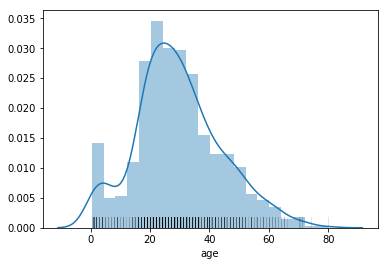

In [7]:
sns.distplot(titanic.age, rug=True, rug_kws={'alpha': .1, 'color': 'k'})

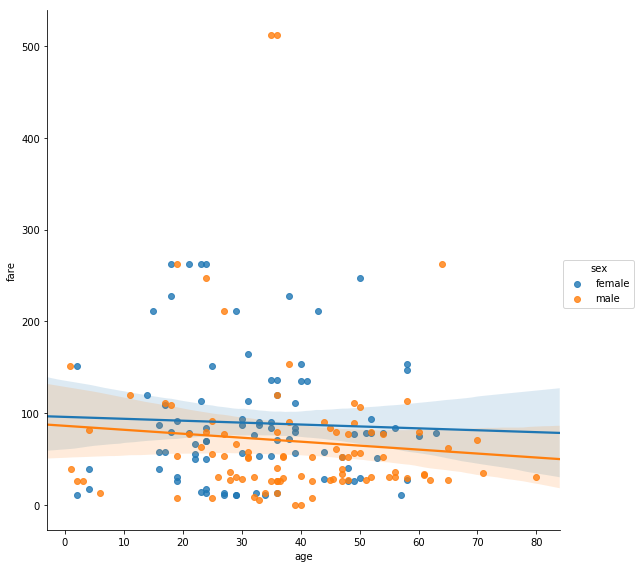

In [4]:
sns.lmplot(x="age", y="fare", hue="sex", data=titanic, size=8)

How about sex and class?

In [5]:
titanic.sex.value_counts()

male      94
female    88
Name: sex, dtype: int64

In [6]:
titanic['class'].value_counts()
# Why couldn't we write `titanic.class.value_counts()` here?

First     157
Second     15
Third      10
Name: class, dtype: int64

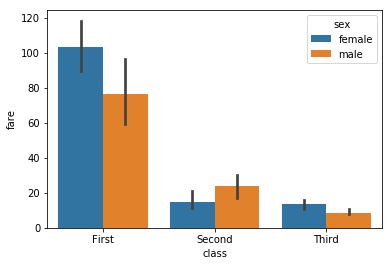

In [7]:
sns.barplot(x="class", hue="sex", y="fare", data=titanic)

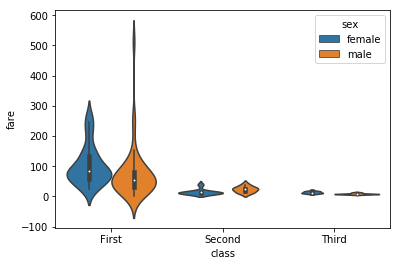

In [8]:
sns.violinplot(x="class", hue="sex", y="fare", data=titanic)

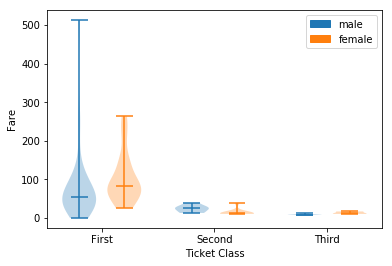

In [9]:
# Can we do this violinplot by hand?
classes = 'First Second Third'.split()
sexes = 'male female'.split()
violin_data = [
    [
        titanic['fare'][(titanic['sex'] == sex) & (titanic['class'] == cls)].values
        for cls in classes
    ] for sex in sexes
]

positions_array = np.arange(len(classes))
v1 = plt.violinplot(violin_data[0], positions=positions_array-.2, widths=.3, showmedians=True, showextrema=True)
v2 = plt.violinplot(violin_data[1], positions=positions_array+.2, widths=.3, showmedians=True, showextrema=True)

# Violin plots don't support legends, so we create patches for labels. This is messy :(
fake_handles = [
    mpatches.Patch(color=v1['cbars'].get_color()[0]),
    mpatches.Patch(color=v2['cbars'].get_color()[0])
]
plt.legend(fake_handles, sexes)

plt.xticks(positions_array, classes)
plt.xlabel("Ticket Class")
plt.ylabel("Fare");

So it looks like fare varies with class, age, and maybe gender, and the way that fare depends on class and age may be different for male vs female.

Let's first do a simple linear regression on age.

In [16]:
model1 = sm.OLS(
    titanic.fare,
    sm.add_constant(titanic['age'])
).fit()
model1.summary()

How do we interpret this?

* How good is this model?
* Does age affect fare? How can we tell? And if so, how?

### Handling categorical variables

Statistical packages generally distinguish between three types of variables:

* **continuous** variables, like age and fare.
* **nominal** variables, like gender and whether the person survived
* **ordinal** variables like cabin class (first > second > third)

(Ordinal variables can often be treated like nominal variables; that's what we'll do for now.)

How do we deal with gender, or class? They're categorical variables. We'll need to use dummy variables to encode them.

In [17]:
titanic_orig = titanic.copy()

<div class="exercise">**Exercise 2**: Create a column `sex_male` that is 1 if the passenger is male, 0 otherwise.</div>

In [18]:
# Your code here


<div class="exercise">**Exercise 3**: Do we need a `sex_female` column, or any others? Why or why not?</div>

**your answer here**


<div class="exercise">**Exercise 4**: Create columns for `class_`</div>

In [19]:
# Your code here


In [20]:
titanic.info()

In [21]:
# Your code here


<div class="exercise">**Exercise 5**: Fit a linear regression including the new sex and class variables.</div>

In [22]:
# Your code here


<div class='exercise'> **Exercise 6** How do we interpret these results?</div>
* All else being equal, what does being male do to the fare?
* What can we say about being *male* and *first-class*?


** Your answer here **

## Interactions

In [23]:
# It seemed like gender interacted with age and class. Can we put that in our model?
titanic['sex_male_X_age'] = titanic['age'] * titanic['sex_male']
model3 = sm.OLS(
    titanic.fare,
    sm.add_constant(titanic[['age', 'sex_male', 'class_Second', 'class_Third', 'sex_male_X_age']])
).fit()
model3.summary()

** What happened to the `age` and `male` terms? **

In [24]:
# It seemed like gender interacted with age and class. Can we put that in our model?
titanic['sex_male_X_class_Second'] = titanic['age'] * titanic['class_Second']
titanic['sex_male_X_class_Third'] = titanic['age'] * titanic['class_Third']
model4 = sm.OLS(
    titanic.fare,
    sm.add_constant(titanic[['age', 'sex_male', 'class_Second', 'class_Third', 'sex_male_X_age', 'sex_male_X_class_Second', 'sex_male_X_class_Third']])
).fit()
model4.summary()

What has happened to the $R^2$ as we added more features? Does this mean that the model is better?

In [25]:
models = [model1, model2, model3, model4]
plt.plot([model.df_model for model in models], [model.rsquared for model in models], 'x-')
plt.xlabel("Model df")
plt.ylabel("$R^2$");

## 2. Model Selection via exhaustive search selection

The dataset for this problem contains 10 simulated predictors and a response variable. 

In [26]:
# Import the dataset
data = pd.read_csv('data/dataset3.txt')
data.head()

**By visually inspecting the data set, do we find that some of the predictors are correlated amongst themselves?**

In [27]:
sns.pairplot(data)

Predictors x1, x2, x3 seem to be perfectly correlated while predictors x4, x5, x6, x7 show very high degrees of correlation.

In [28]:
data.corr()

Let us compute the cofficient of correlation between each pair of predictors, and visualize the matrix of correlation coefficients using a heat map. 

In [29]:
# generating heat map
sns.heatmap(data.corr())

**Do the predictors fall naturally into groups based on the correlation values?**

We can see that higly correlated predictors fall into dark red groups based on correlation values close to 1. Other correlation values also form differently coloured groups.

<div class="exercise">**If you were asked to select a minimal subset of predictors based on the correlation information in order to build a good regression model, how many predictors will you pick, and which ones will you choose? **</div>

** Your answer here **
We may choose one predictor from the x1,x2,x3 list - let's pick x1. <br/>
Similarly, let's pick x6 out of x4,x5,x6,x7. <br/>
The other predictors are not strongly correlated, so we pick them all, i.e. x8,x9,x10. <br/>
Thus, we have picked 5 predictors x1, x6, x8, x9, x10 for our regression model. 

### Model Selection Criteria: Bayesian Information Criterion (BIC)

Generally BIC = -2 x Log-likehood + 2 x log(K)

For least-squares regression specifically,

$$BIC = n \log \Big(\frac{RSS}{n}\Big) + \log(n)*K$$

where, <br/>
RSS = Residual Sum of Squares <br/>
n = the number of obervations <br/>
K = the number of features in our model

### Selecting minimal subset of predictors

Let us apply the exhaustive search variable selection methods discussed in class to choose a minimal subset of predictors that yield high prediction accuracy. We will use the Bayesian Information Criterion (BIC) to choose the subset size.

In [30]:
x = data.iloc[:,:-1]
y = data.iloc[:,-1]
x.shape, y.shape

In [31]:
def find_best_subset_of_size(x, y, num_predictors):
    predictors = x.columns
    
    best_r_squared = -np.inf
    best_model_data = None

    # Enumerate subsets of the given size
    subsets_of_size_k = itertools.combinations(predictors, num_predictors)

    # Inner loop: iterate through subsets_k
    for subset in subsets_of_size_k:

        # Fit regression model using ‘subset’ and calculate R^2 
        # Keep track of subset with highest R^2

        features = list(subset)
        x_subset = sm.add_constant(x[features])

        model = sm.OLS(y, x_subset).fit()
        r_squared = model.rsquared

        # Check if we get a higher R^2 value than than current max R^2.
        # If so, update our best subset 
        if r_squared > best_r_squared:
            best_r_squared = r_squared
            best_model_data = {
                'r_squared': r_squared,
                'subset': features,
                'model': model
            }
    return best_model_data

In [32]:
find_best_subset_of_size(x, y, 8)

In [33]:
def exhaustive_search_selection(x, y):
    """Exhaustively search predictor combinations

    Parameters:
    -----------
    x : DataFrame of predictors/features
    y : response varible 
    
    
    Returns:
    -----------
    
    Dataframe of model comparisons and OLS Model with 
    lowest BIC for subset with highest R^2
    
    """
    
    predictors = x.columns
    
    stats = []
    models = dict()
    
    # Outer loop: iterate over sizes 1, 2 .... d
    for k in range(1, len(predictors)):
        
        best_size_k_model = find_best_subset_of_size(
            x, y, num_predictors=k)
        best_subset = best_size_k_model['subset']
        best_model = best_size_k_model['model']
        
        stats.append({
            'k': k,
            'formula': "y ~ {}".format(' + '.join(best_subset)),
            'bic': best_model.bic,
            'r_squared': best_model.rsquared
        })
        models[k] = best_model
        
    return pd.DataFrame(stats), models

In [34]:
stats, models = exhaustive_search_selection(x, y)
stats

In [35]:
stats.plot(x='k', y='bic', marker='*')

In [36]:
stats.info()

In [37]:
best_stat = stats.iloc[stats.bic.idxmin()]
best_stat

In [38]:
best_k = best_stat['k']
best_bic = best_stat['bic']
best_formula = best_stat['formula']
best_r2 = best_stat['r_squared']

In [39]:
print("The best overall model is `{formula}` with bic={bic:.2f} and R^2={r_squared:.3f}".format(
    formula=best_formula, bic=best_bic, r_squared=best_r2))

In [40]:
models[best_k].summary()

**Do the chosen subsets match the ones you picked using the correlation matrix you had visualized?**

Yes! The predictor subset matches with the ones we picked before.

## Plotting multiple axes in a single figure

![](https://i.imgur.com/XTzSuoR.png)
source: http://matplotlib.org/faq/usage_faq.html

See also [this](http://matplotlib.org/faq/usage_faq.html) matplotlib tutorial.